<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S12/EVA4_Session_12_YOLO_TinyImagenet_with_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S12 _Assignment 12_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **Tiny Imagenet** |
  | _Max. number of epochs_| **50** |
  | _Max. number of parameters_| **NA** |
  | _Architecture_| **ResNet - Custom Architecture** |
  | _Target accurracy_| **50%** |


# Implementation

## Initialization

### Mounting google drive to save results

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install torchsummary
!pip install torchviz
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 51kB 5.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=300b0b46b947afdef7d51edc6c135d9080180c204dc87a2cc37591f1a8b033de
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-en_nrs5j
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-en_nrs5j
     |████████████████████████████████| 634kB 8.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=26e2dbb495861dc8b0d271277bab387db6c00ee1d0cb64acd2ebe50f3dfece56
  Stored in directory: /tmp/pip-ephem-wheel-cache-n_tzmvtd/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1073c06e2fcaa963b3a368355c494fbc145c3c9f4395

In [3]:
!wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
!unzip -qq "./tiny-imagenet-200.zip"

--2020-04-19 15:25:12--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  18.9MB/s    in 15s     

2020-04-19 15:25:28 (15.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
!rm -rf eva
!git clone "https://github.com/siva-sankar-a/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 639 (delta 2), reused 3 (delta 0), pack-reused 631
Receiving objects: 100% (639/639), 8.49 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [5]:
%load_ext autoreload
%autoreload 2
from eva.S12.api import Experiment
from eva.S12.data_manager.data_manager_albumentations import  DataManager
from eva.S12.viz import viz_cifar10_grid_
from eva.S12.utils import textual_summary_tiny_imagenet, graphical_summary_tiny_imagenet
from eva.S12.settings import cifar10_classes
from eva.S12.models.model_s11 import Net
from eva.S12.grad_cam.grad_cam import GradCam
from eva.S12.lr_range_finder.lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import numpy as np

from torch.nn import functional as F
import cv2

# LR range test

In [0]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.25

In [11]:
experiment = Experiment(name=f'default', dataset_name='tiny_imagenet')
experiment.run(epochs=10, 
               momentum=0.9, 
               lr=max_lr, 
               regularization=None, 
               weight_decay=weight_decay, 
               max_lr=max_lr,
               epochs_up=10, 
               base_momentum=0.85,
               div_factor=1e6)

CUDA status: True


  0%|          | 0/1204 [00:00<?, ?it/s]

Found 77000 train images, 33000 validation images


TRAIN : epoch=0 train_loss=0.07596 correct/total=4431/77000 lr=0.03 accuracy=5.75: 100%|██████████| 1204/1204 [04:21<00:00,  4.60it/s]
TEST :  epoch=0 test_loss=4.30274 correct/total=3113/33000 accuracy=9.43: 100%|██████████| 516/516 [00:39<00:00, 13.11it/s]
TRAIN : epoch=1 train_loss=0.06162 correct/total=11568/77000 lr=0.05 accuracy=15.02: 100%|██████████| 1204/1204 [04:21<00:00,  4.61it/s]
TEST :  epoch=1 test_loss=3.70267 correct/total=5907/33000 accuracy=17.90: 100%|██████████| 516/516 [00:39<00:00, 13.07it/s]
TRAIN : epoch=2 train_loss=0.05415 correct/total=17241/77000 lr=0.08 accuracy=22.39: 100%|██████████| 1204/1204 [04:21<00:00,  4.61it/s]
TEST :  epoch=2 test_loss=3.77991 correct/total=5711/33000 accuracy=17.31: 100%|██████████| 516/516 [00:39<00:00, 13.05it/s]
TRAIN : epoch=3 train_loss=0.05125 correct/total=20208/77000 lr=0.10 accuracy=26.24: 100%|██████████| 1204/1204 [04:21<00:00,  4.61it/s]
TEST :  epoch=3 test_loss=3.12928 correct/total=9467/33000 accuracy=28.69: 100%|

Selected max_lr is 0.125 as accuracy stagnates between 0.13 and 0.15

# Training

In [0]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.125

In [9]:
experiment_ocp = Experiment(name=f'default', dataset_name='tiny_imagenet')

CUDA status: True
Found 77000 train images, 33000 validation images


In [12]:
textual_summary_tiny_imagenet(experiment_ocp.model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,728
         MaxPool2d-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,456
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 256,

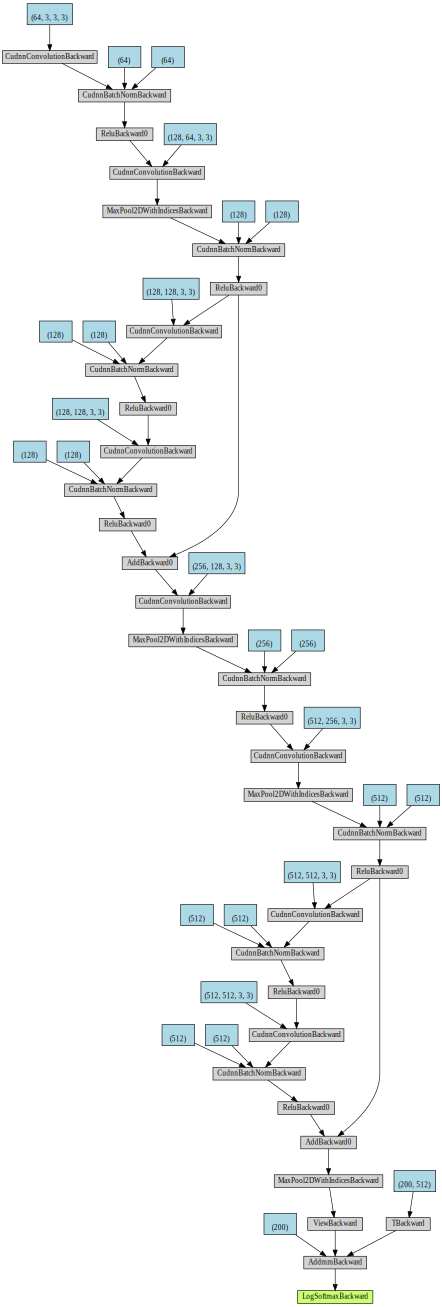

In [13]:
graphical_summary_tiny_imagenet(experiment_ocp.model)

In [10]:
experiment_ocp.run(epochs=50, 
                    momentum=0.9, 
                    lr=max_lr, 
                    regularization=None, 
                    weight_decay=weight_decay, 
                    max_lr=max_lr,
                    epochs_up=5, 
                    base_momentum=0.85,
                    div_factor=10)

TRAIN : epoch=0 train_loss=0.08343 correct/total=2239/77000 lr=0.04 accuracy=2.91: 100%|██████████| 1204/1204 [01:55<00:00, 10.47it/s]
TEST :  epoch=0 test_loss=4.44171 correct/total=2517/33000 accuracy=7.63: 100%|██████████| 516/516 [00:17<00:00, 29.43it/s]
TRAIN : epoch=1 train_loss=0.06432 correct/total=9574/77000 lr=0.06 accuracy=12.43: 100%|██████████| 1204/1204 [01:54<00:00, 10.51it/s]
TEST :  epoch=1 test_loss=3.80527 correct/total=5551/33000 accuracy=16.82: 100%|██████████| 516/516 [00:17<00:00, 30.22it/s]
TRAIN : epoch=2 train_loss=0.05632 correct/total=15423/77000 lr=0.08 accuracy=20.03: 100%|██████████| 1204/1204 [01:54<00:00, 10.49it/s]
TEST :  epoch=2 test_loss=4.41970 correct/total=4473/33000 accuracy=13.55: 100%|██████████| 516/516 [00:16<00:00, 30.36it/s]
TRAIN : epoch=3 train_loss=0.05130 correct/total=19808/77000 lr=0.10 accuracy=25.72: 100%|██████████| 1204/1204 [01:54<00:00, 10.49it/s]
TEST :  epoch=3 test_loss=3.20312 correct/total=9029/33000 accuracy=27.36: 100%|█

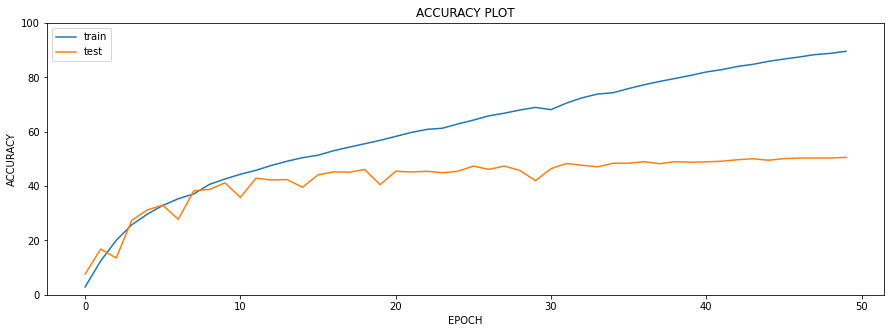

In [16]:
experiment_ocp.load_summary()
experiment_ocp.plot_metric(ylim=[0, 100])

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **89.60** |
| _Best test accuracy_| **50.56** |
| _Best epoch number_| **50** |
| _Parameter count_ | **6,670,600** |